<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required librairies</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the model <b>delta_lorentz</b> corresponding to a 
delta representing a fraction $p$ of fixed atoms and a
Lorentzian corresponding to a Brownian Translational
diffusion model for the remaining $(1-p)$ atoms
</div>

The **reference data** were generated using the above function using the following parameters $p = 0.3$ and $D = 0.145$ AA$^2\times$meV.

The model is convoluted with a Gaussian resolution function 
of Full Width Half Maximum (FWHM) equal to 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

There is no background.

The data are fitted with a general model of a delta + a
Lorentzian, so the fitted parameters are not $p$ and $D$, but
$p$ and a $Q$-dependent HWHM.

### Physical units
Please note that the following units are used for the QENS models

| Type of parameter | Unit          |
| ----------------- |---------------|
| Time              | picosecond    |
| Length            | Angstrom      |
| Momentum transfer | 1/Angstrom    |

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps
    
# check version of bumps installed
# Information message if installed version not recent enough
import bumps

from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

In [3]:
# install QENSmodels (if not already installed)

if not pkgutil.find_loader("QENSmodels"):
    !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

In [4]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'DeltaBrownianDiff_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'DeltaBrownianDiff_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

# Fitting model 
def model_convol(x, q, scale=1, center=0, A0=0, hwhm=1, resolution=None):
    model = QENSmodels.sqwDeltaLorentz(x, q, scale, center, A0, hwhm)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, A0=0.5, hwhm=0.01, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.A0.range(0, 1)
    Mq.hwhm.range(0, 2)
    
    # Q-independent parameters
    if i == 0:
        QA0 = Mq.A0  
    else:
        Mq.A0 = QA0
    M.append(Mq)
        
problem = FitProblem(M)

<h3> Choice of minimizer for bumps </h3>

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description='Minimizer:', options={'Levenberg-Marquardt': 'lm', 'Nelder-Mead Simplex': 'amoeba', 'DRE…

<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

Initial chisq 1475.1170(86)


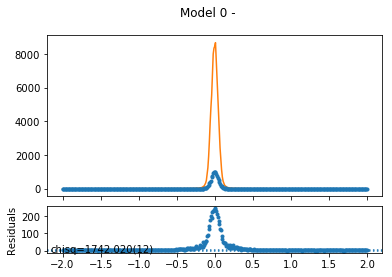

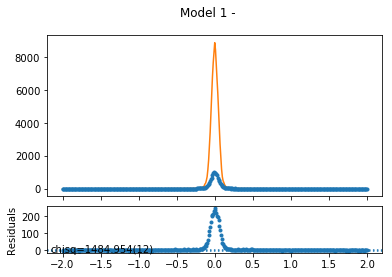

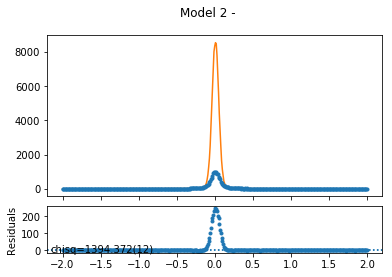

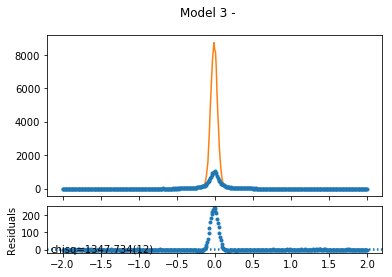

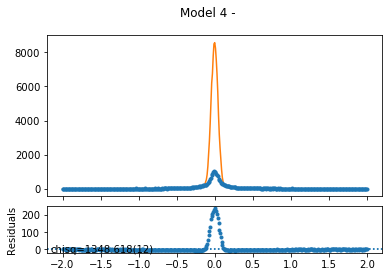

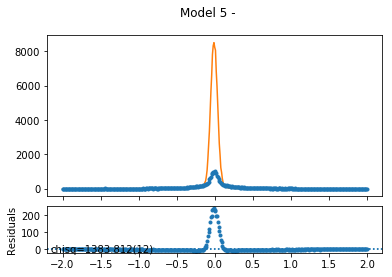

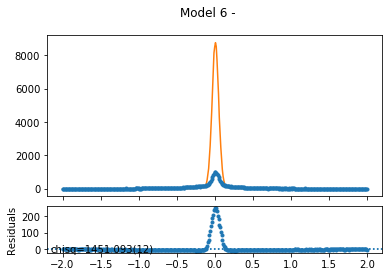

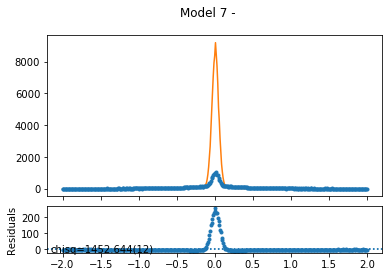

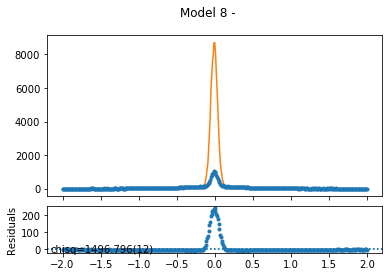

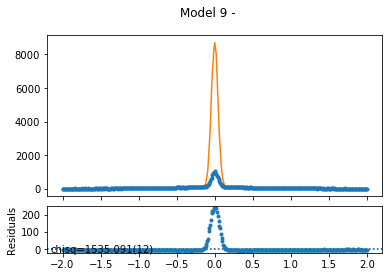

In [7]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [8]:
result = fit(problem, 
             method=w_choice_minimizer.value, 
             steps=steps, 
             verbose=True)

final chisq 0.9774(86)
=== Uncertainty est. from curvature: par    dx           dx/sqrt(chisq) ===
                                      A0 0.3022(17)      0.3022(17)     
                                  center 0.00199(73)     0.00199(74)    
                                    hwhm 0.00528(37)     0.00528(37)    
                                   scale 111.1(26)       111.1(27)      
                                  center -0.55(78)e-3    -0.55(79)e-3   
                                    hwhm 0.02082(58)     0.02082(59)    
                                   scale 135.4(12)       135.4(12)      
                                  center -0.00105(99)    -1.1(10)e-3    
                                    hwhm 0.04861(93)     0.04861(94)    
                                   scale 166.1(13)       166.1(13)      
                                  center 0.00(10)e9      0.00(10)e9     
                                    hwhm 0.0854(14)      0.0854(14)     
                         

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

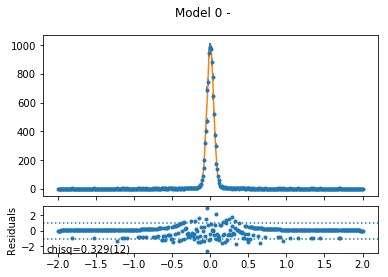

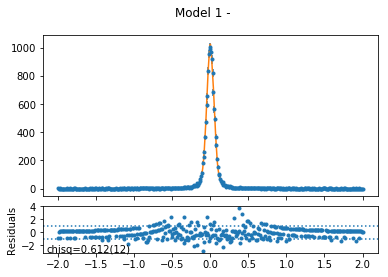

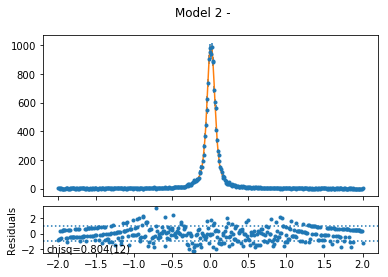

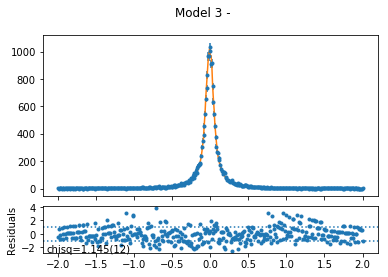

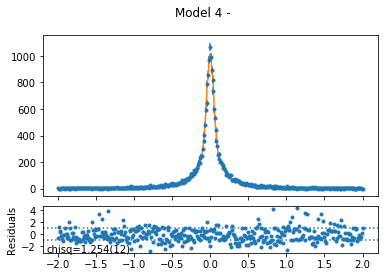

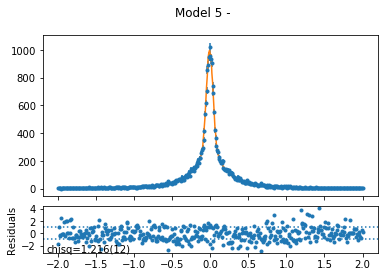

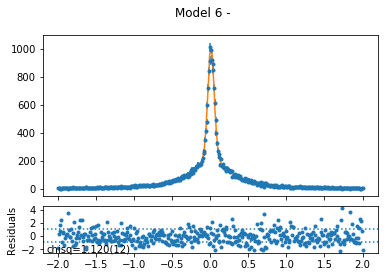

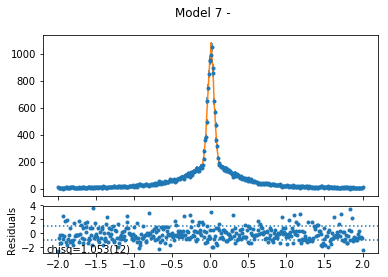

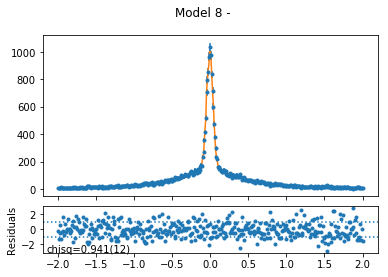

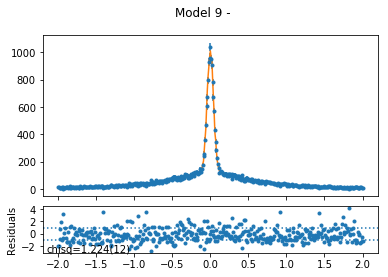

In [9]:
problem.plot()

In [10]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 0.9774(86)
A0 : 0.3022(17)
center : 0.00199(73)
hwhm : 0.00528(37)
scale : 111.1(26)
center : -0.55(78)e-3
hwhm : 0.02082(58)
scale : 135.4(12)
center : -0.00105(99)
hwhm : 0.04861(93)
scale : 166.1(13)
center : 0.00(10)e9
hwhm : 0.0854(14)
scale : 200.4(14)
center : -1.0(18)e-3
hwhm : 0.1371(20)
scale : 233.5(16)
center : -1.2(22)e-3
hwhm : 0.1917(27)
scale : 256.5(16)
center : -4.6(29)e-3
hwhm : 0.2679(37)
scale : 271.5(17)
center : 0.004999701(29)
hwhm : 0.3648(49)
scale : 292.3(18)
center : 0.3(53)e-3
hwhm : 0.4495(63)
scale : 298.0(19)
center : -1.4(55)e-3
hwhm : 0.5427(76)
scale : 308.2(20)
